In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Recurrent Neural Networks

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

37658

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 35 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE       ': 4,
 'D.G. ORGANIZZAZIONE                                   ': 5,
 'D.G. ORGANIZZAZIONE E RISORSE                         ': 6,
 'D.G. POLITICHE TERRITORIALI, AMBIENTALI E PER LA MOBIL': 7,
 'D.G. PRESIDENZA                                       ': 8,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 9,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 10,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 11,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 12,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 13,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 14,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 15,
 'DIPARTIMENTO SVILUPPO ECONOMICO           

## Data Preparation

We need to create the function that transform the x and y.
In this case we need to:
- x: pad the sequences
- y: one hot encoding

In [4]:
maxlen = max([len(x) for x in x_train])
maxlen

166

In [5]:
from functools import partial

def x_transformer(x_data):
    return partial(tf.keras.preprocessing.sequence.pad_sequences, x_data, maxlen, padding='post')

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [29]:
batch_size = 512
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.7)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 35
training size 100573, validation size 43102


In [30]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## Models

We evaluate: 
- CNN
- LSTM and GRU models with dropout, 
- reverse the text order and uses Bidirectional-LSTM 

### CNN

In [8]:
def build_model_cnn(num_words, num_classes, embed_size, dropout=0.2):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Conv1D(64,3, activation='relu')(embed_l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.MaxPooling1D(2)(l)
    l = tf.keras.layers.Conv1D(128,3, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.GlobalMaxPool1D()(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(32, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
cnn_model = build_model_cnn(num_words, num_classes, 100, dropout=0.2)
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 164, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 82, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 128)           0         
__________

In [10]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('cnn', '64_128_256_128_64')),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
    ]  

In [12]:
cnn_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=20, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/20
786/786 [==============================] - 18s 23ms/step - loss: 1.8664 - acc: 0.4285 - val_loss: 1.6490 - val_acc: 0.4839
Epoch 2/20
786/786 [==============================] - 18s 23ms/step - loss: 1.6240 - acc: 0.4895 - val_loss: 1.4673 - val_acc: 0.5523
Epoch 3/20
786/786 [==============================] - 18s 23ms/step - loss: 1.4587 - acc: 0.5381 - val_loss: 1.3246 - val_acc: 0.5896
Epoch 4/20
786/786 [==============================] - 18s 23ms/step - loss: 1.3364 - acc: 0.5752 - val_loss: 1.2863 - val_acc: 0.5959
Epoch 5/20
786/786 [==============================] - 18s 23ms/step - loss: 1.2495 - acc: 0.6001 - val_loss: 1.1620 - val_acc: 0.6318
Epoch 6/20
786/786 [==============================] - 18s 23ms/step - loss: 1.1688 - acc: 0.6256 - val_loss: 1.1222 - val_acc: 0.6397
Epoch 7/20
786/786 [==============================] - 18s 23ms/step - loss: 1.1161 - acc: 0.6437 - val_loss: 1.1308 - val_acc: 0.6431
Epoch 8/20
786/786 [==============================] - 18s 23ms

### GRU

In [13]:
def build_model_gru(neurons, num_words, num_class, embed_size, dropout, rec_dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(neurons, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=False)
    )(embed_l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model 

In [14]:
neurons = 64

gru_model = build_model_gru(neurons, num_words, num_classes, 100, 0.25, 0.15)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('gru', neurons)),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ] 

gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               63360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                4515      
Total params: 3,850,699
Trainable params: 3,850,443
Non-trainable params: 256
________________________________________________________________

In [15]:
import gc
gc.collect()

179

In [16]:
history = gru_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=12, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/100
786/786 [==============================] - 315s 400ms/step - loss: 2.5439 - acc: 0.2969 - val_loss: 1.8736 - val_acc: 0.4500
Epoch 2/100
786/786 [==============================] - 313s 399ms/step - loss: 1.6282 - acc: 0.5075 - val_loss: 1.3136 - val_acc: 0.5863
Epoch 3/100
786/786 [==============================] - 322s 410ms/step - loss: 1.2424 - acc: 0.6042 - val_loss: 1.1145 - val_acc: 0.6424
Epoch 4/100
786/786 [==============================] - 316s 402ms/step - loss: 1.0274 - acc: 0.6670 - val_loss: 1.0068 - val_acc: 0.6735
Epoch 5/100
786/786 [==============================] - 318s 405ms/step - loss: 0.8952 - acc: 0.7075 - val_loss: 0.9610 - val_acc: 0.6882
Epoch 6/100
786/786 [==============================] - 317s 403ms/step - loss: 0.7962 - acc: 0.7351 - val_loss: 0.9220 - val_acc: 0.7012
Epoch 7/100
786/786 [==============================] - 316s 402ms/step - loss: 0.7233 - acc: 0.7581 - val_loss: 0.9062 - val_acc: 0.7098
Epoch 8/100
786/786 [====================

In [8]:
import gc
gc.collect()

3

## LSTM

In [22]:
def build_model_lstm(neurons, num_words, num_class, embed_size, dropout, rec_dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(neurons, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=False)
    )(embed_l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model 

In [26]:
lstm_model = build_model_lstm(16, num_words, num_classes, 100, 0.25, 0.15)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                14976     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                4515      
Total params: 3,789,515
Trainable params: 3,789,515
Non-trainable params: 0
_________________________________________________________________


In [27]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('lstm', '64')),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ]  

In [ ]:
history = lstm_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=13, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks, workers=10)

Epoch 1/13
197/197 [==============================] - 106s 537ms/step - loss: 6.2207 - acc: 0.0681 - val_loss: 3.3761 - val_acc: 0.0848
Epoch 2/13
196/197 [============================>.] - ETA: 0s - loss: 6.1056 - acc: 0.0723

Here we can see that without any parameter optimization we get best results with CNN 

## Build the final model

the best model is obtained embedding of size 64

In [10]:
import gc
gc.collect()

0

In [11]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [13]:
embed_size = 100
model = build_model_cnn(num_words, num_classes, embed_size)
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 164, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 82, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 128)           0         
__________

In [14]:
history = model.fit_generator(train_generator, train_steps, 8)

Epoch 1/8
1123/1123 [==============================] - 41s 36ms/step - loss: 2.9033 - acc: 0.1886
Epoch 2/8
1123/1123 [==============================] - 39s 34ms/step - loss: 2.1369 - acc: 0.3655
Epoch 3/8
1123/1123 [==============================] - 39s 34ms/step - loss: 1.7214 - acc: 0.4637
Epoch 4/8
1123/1123 [==============================] - 39s 34ms/step - loss: 1.4906 - acc: 0.5256
Epoch 5/8
1123/1123 [==============================] - 39s 35ms/step - loss: 1.3463 - acc: 0.5671
Epoch 6/8
1123/1123 [==============================] - 39s 35ms/step - loss: 1.2518 - acc: 0.5984
Epoch 7/8
1123/1123 [==============================] - 39s 35ms/step - loss: 1.1696 - acc: 0.6216
Epoch 8/8
1123/1123 [==============================] - 39s 35ms/step - loss: 1.1120 - acc: 0.6410


## Evaluate on the test set

In [17]:
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen)

In [18]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [19]:
test_predictions = gru_model.predict(x_test_pad, verbose=1)

35919/35919 [==============================] - 123s 3ms/step


In [20]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.5803056877975444
precision  0.6607707093397954
recall  0.5803056877975444
f-measure  0.5838605603114468


However, by checking the results on the test set we got lower f-measure than the model trained with vectorized representation. Let's take a step more and plot the results.

### Report the classification result for each class

In [16]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.05      0.01      0.02       158
          1       0.31      0.02      0.03       217
          2       0.77      0.70      0.73       686
          3       0.75      0.67      0.71      2765
          4       0.61      0.66      0.63      1658
          5       0.44      0.48      0.46       289
          6       0.38      0.49      0.43       606
          7       0.24      0.10      0.14       316
          8       0.36      0.68      0.47       669
          9       0.78      0.63      0.70      1432
         10       0.49      0.59      0.54       542
         11       0.48      0.62      0.54       767
         12       0.45      0.73      0.55       985
         13       0.96      0.90      0.93      2718
         14       0.85      0.59      0.70       370
         15       0.97      0.84      0.90      1142
         16       0.84      0.64      0.72      1890
         17       0.55      0.40      0.46   

### Confusion Matrix

In [17]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [18]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


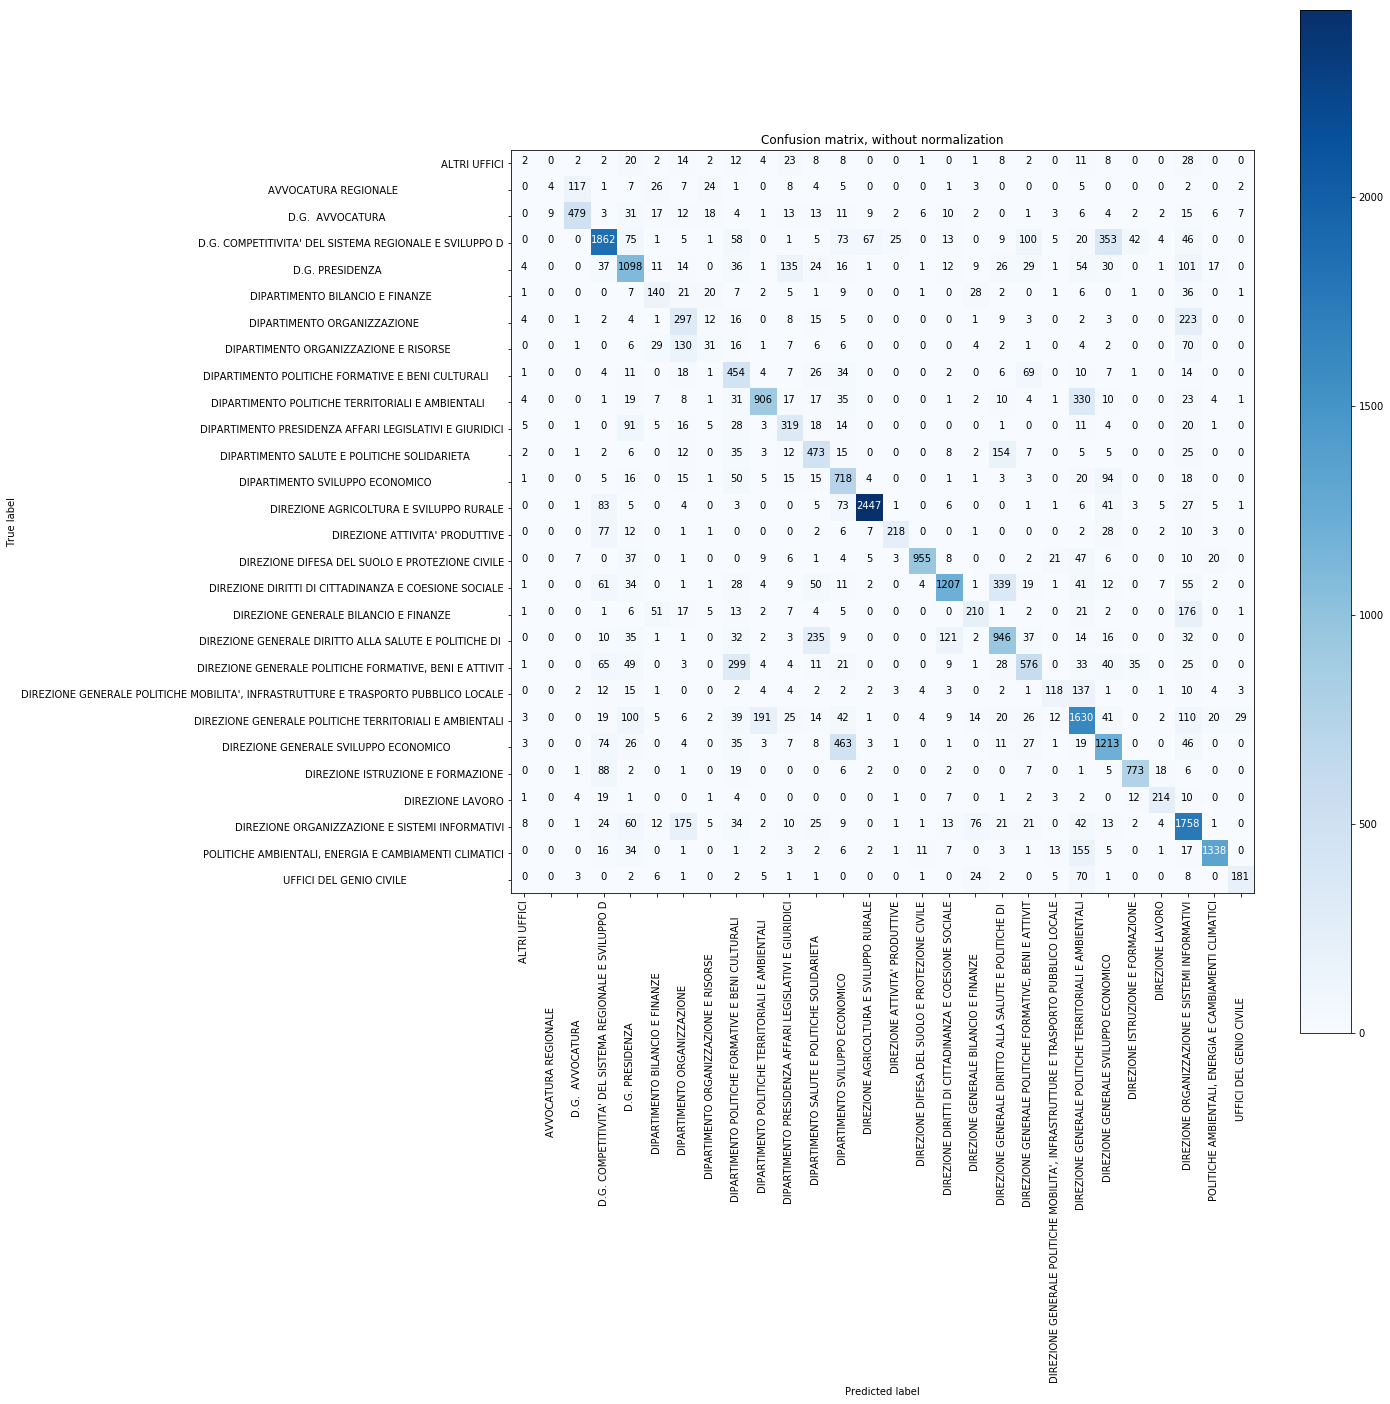

In [19]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')